## Background

In this blog post I'll work through the first exercise given in the "Further Research" section of Chapter 9 of the fastai textbook:

> Pick a competition on Kaggle with tabular data (current or past) and try to adapt the techniques seen in this chapter to get the best possible results. Compare your results to the private leaderboard.

I'll use the dataset from the [Zillow Prize: Zillow’s Home Value Prediction (Zestimate)](https://www.kaggle.com/competitions/zillow-prize-1/data?select=train_2017.csv) competition, and work through each section in the chapter.

> In this competition, Zillow is asking you to predict the log-error between their Zestimate and the actual sale price, given all the features of a home. The log error is defined as $logerror = log(Zestimate)-log(SalePrice)$. Submissions are evaluated on Mean Absolute Error between the predicted log error and the actual log error.


I get the following results by the end of the exercise:


|Model|Mean Absolute Error|
|:-:|:-:|
|Random Forest|0.072|
|Neural Net|0.117|
|Ensemble of both|0.086|

The first place entry on the private leaderboard had an error of 0.074.

## Load the Data

In [ ]:
!pip install dtreeviz
!pip install treeinterpreter
!pip install waterfallcharts

from pandas.api.types import is_string_dtype, is_numeric_dtype, is_categorical_dtype
from fastai.tabular.all import *
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from dtreeviz.trees import *
from IPython.display import Image, display_svg, SVG

pd.options.display.max_rows = 20
pd.options.display.max_columns = 8

from sklearn.tree import DecisionTreeClassifier, export_graphviz

import graphviz

def draw_tree(t, df, size=10, ratio=0.6, precision=2, **kwargs):
  s=export_graphviz(t, out_file=None, feature_names=df.columns, filled=True, rounded=True,
                    special_characters=True, rotate=False, precision=precision, **kwargs)
  return graphviz.Source(re.sub('Tree {', f'Tree {{ size={size}; ratio={ratio}', s))

import dtreeviz
from fastcore.all import *

In [3]:
from pathlib import Path

cred_path = Path("~/.kaggle/kaggle.json").expanduser()
if not cred_path.exists():
  cred_path.parent.mkdir(exist_ok=True)
  cred_path.write_text(creds)
  cred_path.chmod(0o600)

In [4]:
import zipfile,kaggle

path = Path('zillow-prize-1')
if not path.exists():
  kaggle.api.competition_download_cli(str(path))
  zipfile.ZipFile(f'{path}.zip').extractall(path)

100%|██████████| 340M/340M [00:04<00:00, 84.9MB/s]


In [5]:
path.ls(file_type='text')

(#5) [Path('zillow-prize-1/train_2017.csv'),Path('zillow-prize-1/sample_submission.csv'),Path('zillow-prize-1/train_2016_v2.csv'),Path('zillow-prize-1/properties_2016.csv'),Path('zillow-prize-1/properties_2017.csv')]

In [6]:
properties_2016 = pd.read_csv(path/'properties_2016.csv', low_memory=False)
df = pd.read_csv(path/'train_2016_v2.csv', low_memory=False)

In [7]:
df.shape

(90275, 3)

In [8]:
df = df.merge(properties_2016, how='left', left_on='parcelid', right_on='parcelid')

In [9]:
df.shape

(90275, 60)

In [10]:
df.head()

,parcelid,logerror,transactiondate,airconditioningtypeid,...,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock
0,11016594,0.0276,2016-01-01,1.0,...,6735.88,NaN,NaN,6.037107e+13
1,14366692,-0.1684,2016-01-01,NaN,...,10153.02,NaN,NaN,NaN
2,12098116,-0.0040,2016-01-01,1.0,...,11484.48,NaN,NaN,6.037464e+13
3,12643413,0.0218,2016-01-02,1.0,...,3048.74,NaN,NaN,6.037296e+13
4,14432541,-0.0050,2016-01-02,NaN,...,5488.96,NaN,NaN,6.059042e+13


Currently I'm mainly looking for situations where `parcelid` is NA since that would indicate an issue in my `merge`. Looks like all `parcelid`s are accounted for:

In [11]:
df.isna().sum()

parcelid                        0
logerror                        0
transactiondate                 0
airconditioningtypeid       61494
architecturalstyletypeid    90014
                            ...  
landtaxvaluedollarcnt           1
taxamount                       6
taxdelinquencyflag          88492
taxdelinquencyyear          88492
censustractandblock           605
Length: 60, dtype: int64

The dependent variable is `logerror`. Most of the `logerror` values are between +/- 0.25.

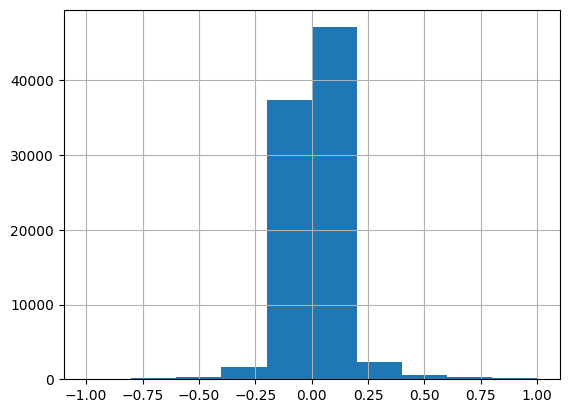

In [12]:
df.logerror.hist(range=[-1, 1]);

The competition's data page doesn't highlight any particular columns, so I'll take a look at a few of them:

In [13]:
df.columns

Index(['parcelid', 'logerror', 'transactiondate', 'airconditioningtypeid',
       'architecturalstyletypeid', 'basementsqft', 'bathroomcnt', 'bedroomcnt',
       'buildingclasstypeid', 'buildingqualitytypeid', 'calculatedbathnbr',
       'decktypeid', 'finishedfloor1squarefeet',
       'calculatedfinishedsquarefeet', 'finishedsquarefeet12',
       'finishedsquarefeet13', 'finishedsquarefeet15', 'finishedsquarefeet50',
       'finishedsquarefeet6', 'fips', 'fireplacecnt', 'fullbathcnt',
       'garagecarcnt', 'garagetotalsqft', 'hashottuborspa',
       'heatingorsystemtypeid', 'latitude', 'longitude', 'lotsizesquarefeet',
       'poolcnt', 'poolsizesum', 'pooltypeid10', 'pooltypeid2', 'pooltypeid7',
       'propertycountylandusecode', 'propertylandusetypeid',
       'propertyzoningdesc', 'rawcensustractandblock', 'regionidcity',
       'regionidcounty', 'regionidneighborhood', 'regionidzip', 'roomcnt',
       'storytypeid', 'threequarterbathnbr', 'typeconstructiontypeid',
       'unitcn

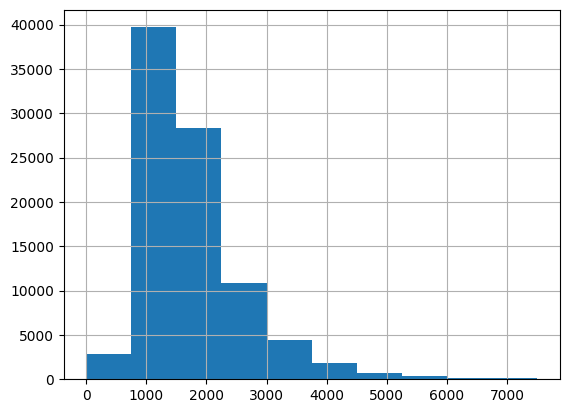

In [16]:
df.calculatedfinishedsquarefeet.hist(range=[0,7500]);

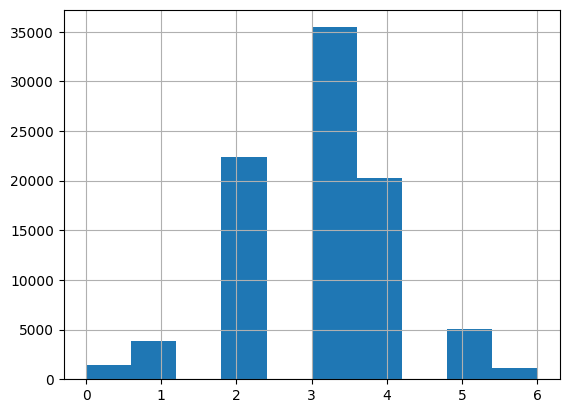

In [17]:
df.bedroomcnt.hist(range=[0,6]);

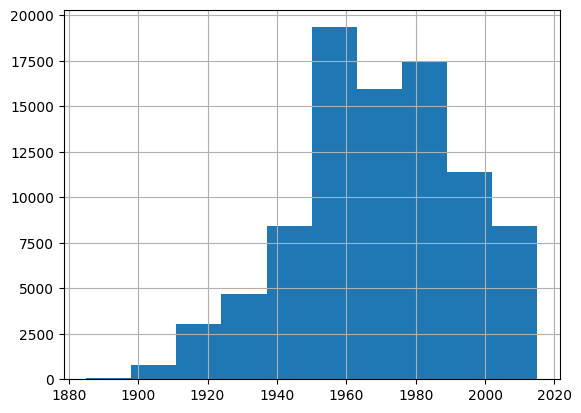

In [18]:
df.yearbuilt.hist();

## Data Cleaning

### Handle Ordinal Columns

I'm not displaying the output here, but I looped through all of the columns and looked at their unique values to see if there were opportunities to set ordinal values---I did not find any.

In [ ]:
for col in df.columns:
  print(col, df[col].unique(), len(df[col].unique()))
  print(" ")

### Handle Dates

The only date field is `transactiondate` which is currently stored in the `DataFrame` as a `str`. I'll convert it to a `datetime` object.

In [19]:
type(df.transactiondate[0])

str

In [20]:
df['transactiondate'] = pd.to_datetime(df['transactiondate'])

In [21]:
df.transactiondate[0], type(df.transactiondate[0])

(Timestamp('2016-01-01 00:00:00'), pandas._libs.tslibs.timestamps.Timestamp)

I'll use the fastai `add_datepart` function to add additional columns associated with the `transactiondate`. I want to keep `transactiondate` field intact to make it easier to split the training and validation sets.

In [22]:
len(df.columns)

60

In [23]:
transactiondate = df['transactiondate']
df = add_datepart(df, 'transactiondate')

In [24]:
len(df.columns)

72

In [25]:
' '.join(o for o in df.columns if o.startswith('transaction'))

'transactionYear transactionMonth transactionWeek transactionDay transactionDayofweek transactionDayofyear transactionIs_month_end transactionIs_month_start transactionIs_quarter_end transactionIs_quarter_start transactionIs_year_end transactionIs_year_start transactionElapsed'

In [26]:
df['transactiondate'] = transactiondate

## Define the Training and Validation Sets

The data page of the competition states that the training data contains transactions mostly before 10/15/2016, whereas the test data contains transactions between 10/15/2016 and 12/31/2016. I'll use the same split for my data.

There are 85670 records before October 15, 2016, and 4605 records on or after. These will become the training and validation sets, respectively.

In [27]:
len(df[df['transactiondate'] < '2016-10-15'])

85670

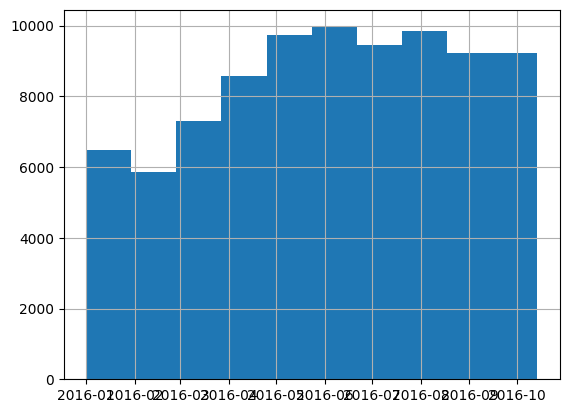

In [28]:
df[df['transactiondate'] < '2016-10-15'].transactiondate.hist();

In [29]:
len(df[df['transactiondate'] >= '2016-10-15'])

4605

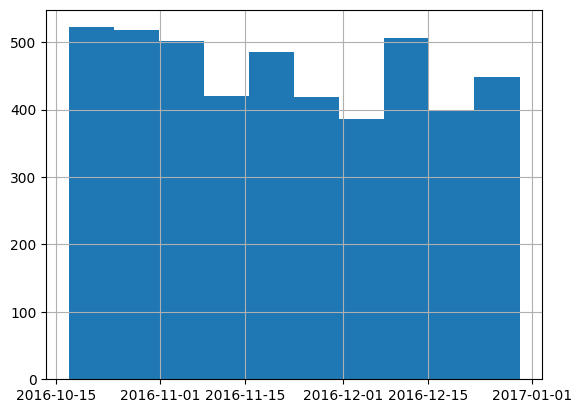

In [30]:
df[df['transactiondate'] >= '2016-10-15'].transactiondate.hist();

In [31]:
dep_var = 'logerror'

In [32]:
cond = df.transactiondate < '2016-10-15'
train_idx = np.where( cond)[0]
valid_idx = np.where(~cond)[0]
splits = (list(train_idx), list(valid_idx))

In [33]:
len(train_idx), len(valid_idx)

(85670, 4605)

## Create the Decision Tree

I'll setup the `TabularPandas` object first, as done in the text:

In [34]:
procs = [Categorify, FillMissing]

In [35]:
cont,cat = cont_cat_split(df, 1, dep_var=dep_var)

In [36]:
cat

['hashottuborspa',
 'propertycountylandusecode',
 'propertyzoningdesc',
 'fireplaceflag',
 'taxdelinquencyflag',
 'transactionYear',
 'transactionIs_month_end',
 'transactionIs_month_start',
 'transactionIs_quarter_end',
 'transactionIs_quarter_start',
 'transactionIs_year_end',
 'transactionIs_year_start',
 'transactiondate']

In [37]:
to = TabularPandas(df, procs, cat, cont, y_names=dep_var, splits=splits)

In [38]:
type(to)

fastai.tabular.core.TabularPandas

In [39]:
len(to.train), len(to.valid)

(85670, 4605)

In [40]:
to.show(3)

,hashottuborspa,propertycountylandusecode,propertyzoningdesc,fireplaceflag,taxdelinquencyflag,transactionYear,transactionIs_month_end,transactionIs_month_start,transactionIs_quarter_end,transactionIs_quarter_start,transactionIs_year_end,transactionIs_year_start,transactiondate,airconditioningtypeid_na,architecturalstyletypeid_na,basementsqft_na,buildingclasstypeid_na,buildingqualitytypeid_na,calculatedbathnbr_na,decktypeid_na,finishedfloor1squarefeet_na,calculatedfinishedsquarefeet_na,finishedsquarefeet12_na,finishedsquarefeet13_na,finishedsquarefeet15_na,finishedsquarefeet50_na,finishedsquarefeet6_na,fireplacecnt_na,fullbathcnt_na,garagecarcnt_na,garagetotalsqft_na,heatingorsystemtypeid_na,lotsizesquarefeet_na,poolcnt_na,poolsizesum_na,pooltypeid10_na,pooltypeid2_na,pooltypeid7_na,regionidcity_na,regionidneighborhood_na,regionidzip_na,storytypeid_na,threequarterbathnbr_na,typeconstructiontypeid_na,unitcnt_na,yardbuildingsqft17_na,yardbuildingsqft26_na,yearbuilt_na,numberofstories_na,structuretaxvaluedollarcnt_na,taxvaluedollarcnt_na,landtaxvaluedollarcnt_na,taxamount_na,taxdelinquencyyear_na,censustractandblock_na,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,decktypeid,finishedfloor1squarefeet,calculatedfinishedsquarefeet,finishedsquarefeet12,finishedsquarefeet13,finishedsquarefeet15,finishedsquarefeet50,finishedsquarefeet6,fips,fireplacecnt,fullbathcnt,garagecarcnt,garagetotalsqft,heatingorsystemtypeid,latitude,longitude,lotsizesquarefeet,poolcnt,poolsizesum,pooltypeid10,pooltypeid2,pooltypeid7,propertylandusetypeid,rawcensustractandblock,regionidcity,regionidcounty,regionidneighborhood,regionidzip,roomcnt,storytypeid,threequarterbathnbr,typeconstructiontypeid,unitcnt,yardbuildingsqft17,yardbuildingsqft26,yearbuilt,numberofstories,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyyear,censustractandblock,transactionMonth,transactionWeek,transactionDay,transactionDayofweek,transactionDayofyear,transactionElapsed,logerror
0,#na#,0100,LARS,#na#,#na#,2016,False,True,False,True,False,True,2016-01-01,False,True,True,True,False,False,True,True,False,False,True,True,True,True,True,False,True,True,False,False,True,True,True,True,True,False,False,False,True,True,True,False,True,True,False,True,False,False,False,False,True,False,11016594,1.0,7.0,643.5,2.0,3.0,4.0,4.0,2.0,66.0,1247.0,1684.0,1684.0,1440.0,2101.5,1250.0,1921.0,6037.0,1.0,2.0,2.0,432.0,2.0,34280992.0,-118488536.0,7528.0,1.0,500.0,1.0,1.0,1.0,261.0,60371068.0,12447.0,3101.0,31817.0,96370.0,0.0,7.0,1.0,6.0,1.0,260.0,156.0,1959.0,1.0,122754.0,360170.0,2015.0,237416.0,6735.879883,14.0,6.037107e+13,1,53,1,4,1,1.451606e+09,0.0276
1,#na#,1,#na#,#na#,#na#,2016,False,True,False,True,False,True,2016-01-01,True,True,True,True,True,False,True,True,False,False,True,True,True,True,True,False,False,False,True,False,True,True,True,True,True,False,True,False,True,False,True,True,True,True,False,True,False,False,False,False,True,True,14366692,1.0,7.0,643.5,3.5,4.0,4.0,7.0,3.5,66.0,1247.0,2263.0,2263.0,1440.0,2101.5,1250.0,1921.0,6059.0,1.0,3.0,2.0,468.0,2.0,33668120.0,-117677552.0,3643.0,1.0,500.0,1.0,1.0,1.0,261.0,60590524.0,32380.0,1286.0,118887.0,96962.0,0.0,7.0,1.0,6.0,1.0,260.0,156.0,2014.0,1.0,346458.0,585529.0,2015.0,239071.0,10153.019531,14.0,6.037620e+13,1,53,1,4,1,1.451606e+09,-0.1684
2,#na#,0100,PSR6,#na#,#na#,2016,False,True,False,True,False,True,2016-01-01,False,True,True,True,False,False,True,True,False,False,True,True,True,True,True,False,True,True,False,False,True,True,True,True,True,False,False,False,True,True,True,False,True,True,False,True,False,False,False,False,True,False,12098116,1.0,7.0,643.5,3.0,2.0,4.0,4.0,3.0,66.0,1247.0,2217.0,2217.0,1440.0,2101.5,1250.0,1921.0,6037.0,1.0,3.0,2.0,432.0,2.0,34136312.0,-118175032.0,11423.0,1.0,500.0,1.0,1.0,1.0,261.0,60374640.0,47019.0,3101.0,275411.0,96293.0,0.0,7.0,1.0,6

Underlying values for categorical variables are numeric:

In [41]:
to.items[['transactionYear', 'transactionIs_month_end', 'transactionIs_month_start']].head(3)

,transactionYear,transactionIs_month_end,transactionIs_month_start
0,1,1,2
1,1,1,2
2,1,1,2


Now I can build the decision tree following the steps given in the textbook:

In [42]:
# make sure logerror looks good
to.train.y[:5]

0    0.0276
1   -0.1684
2   -0.0040
3    0.0218
4   -0.0050
Name: logerror, dtype: float32

In [43]:
xs,y = to.train.xs, to.train.y
valid_xs, valid_y = to.valid.xs, to.valid.y

In [44]:
m = DecisionTreeRegressor(max_leaf_nodes=4)
m.fit(xs,y);

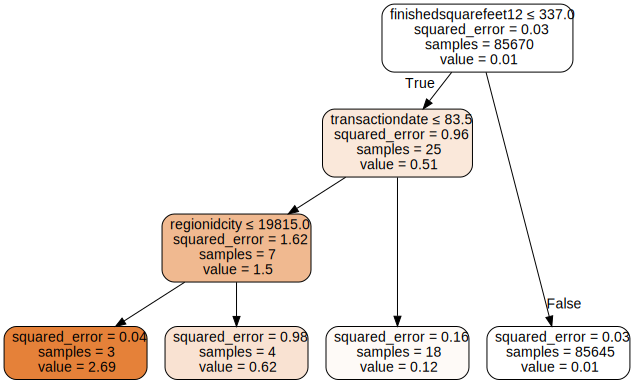

In [45]:
draw_tree(m, xs, size=10, leaves_parallel=True, precision=2)

The smallest average `logerror` value in this model is when `finishedsquarefeet12` (which according to their data dictionary is the "Finished living area") is greater than 337, which is for 85645 rows which is basically the whole training set.

### View the Data for Outliers

As done in the book, I'll look at a sample of the data and visualize it in more detail:

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names


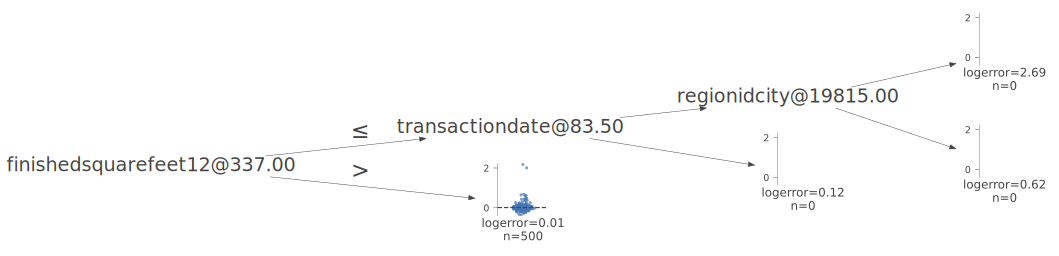

In [46]:
samp_idx = np.random.permutation(len(y))[:500]

viz_model=dtreeviz.model(m,
                         X_train=xs.iloc[samp_idx],
                         y_train=y.iloc[samp_idx],
                         feature_names=xs.columns,
                         target_name=dep_var)

viz_model.view(fontname='DejaVu Sans', scale=1.6, label_fontsize=10,
               orientation='LR', fancy=False)

In this case, since such a large portion of the data falls into the split of `finishedsquarefeet12 > 337`, the visualization is not helpful as there are 0 or just a few values left for the other splits even at larger sample sizes (I tried 500, 1000 and 5000).

As done in the text, I'll now build a bigger tree without passing it any stopping criteria, and create a loss function (mean absolute error) to match the competition:

In [47]:
m = DecisionTreeRegressor()
m.fit(xs,y);

In [48]:
def mae(pred, y): return (pred - y).abs().mean()
def m_mae(m, xs, y): return mae(m.predict(xs), y)

Here's the mean absolute error on the training set:

In [49]:
m_mae(m, xs, y)

0.0

Here's the mean absolute error on the validation set:

In [51]:
m_mae(m, valid_xs, valid_y)

0.15422440832733592

The validation error is much larger than the training set error because the model is overfitting! As was the case in the textbook, the reason is that we have almost as many leaf nodes as we do training sample. It's basically memorizing the training set.

In [52]:
m.get_n_leaves(), len(xs)

(83323, 85670)

I'll use the same stopping criteria as the text (every leaf node should contain at least 25 rows) and create a new model:

In [53]:
m = DecisionTreeRegressor(min_samples_leaf=25)
m.fit(to.train.xs, to.train.y)
m_mae(m, xs, y), m_mae(m, valid_xs, valid_y)

(0.07031707298053898, 0.08723056533912212)

The validation and training set errors are now similar.

In [54]:
m.get_n_leaves(), m.get_n_leaves()/len(xs)

(2688, 0.03137621104237189)

We now have about 3% as many leaves as we do training samples.

## Creating a Random Forest

I'll use mostly the same random forest function as is used in the text, except for `max_samples` I'll use `40_000` which is about half of my training set (they used `200_000` which was about half of their training set).

In [55]:
def rf(xs, y, n_estimators=40, max_samples=40_000, max_features=0.5, min_samples_leaf=5, **kwargs):
  return RandomForestRegressor(n_jobs=-1, n_estimators=n_estimators, max_samples=max_samples,
                               max_features=max_features, min_samples_leaf=min_samples_leaf,
                               oob_score=True).fit(xs,y)

In [56]:
m = rf(xs, y);

In [57]:
m_mae(m, xs, y), m_mae(m, valid_xs, valid_y)

(0.05653021493284958, 0.07388558834504737)

Both the training and validation set errors are lower than a model with a single decision tree.

As done in the textbook, I'll plot how the mean absolute error changes as the number of trees used for predictions increases.

In [ ]:
preds = np.stack([t.predict(valid_xs) for t in m.estimators_]);

In [59]:
preds.shape

(40, 4605)

The model's validation error is the same as the error between the mean prediction across all trees and the validation set.



In [60]:
mae(preds.mean(0), valid_y)

0.07388558834504737

In [61]:
preds.mean(0).shape

(4605,)

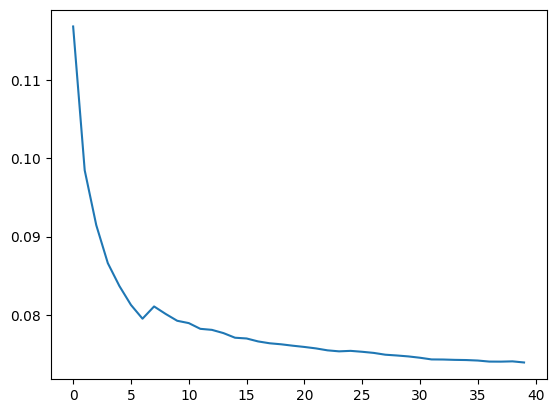

In [62]:
plt.plot([mae(preds[:i+1].mean(0), valid_y) for i in range(40)]);

As the number of trees used for prediction increases, the mean absolute error on the validation set decreases. This decrease doesn't fully flatten out like it did in the textbook example, so I could probably use more trees to get a better result.

Next I'll calculate the out-of-bag error and compare it with the validation error. I use the training targets `y` since out-of-bag predictions are calculated using different subsets of the training data.

In [63]:
len(m.oob_prediction_)

85670

In [64]:
mae(m.oob_prediction_, y)

0.07103692229370927

As is the case in the text, the OOB error is a bit smaller than the validation error.

## Model Interpretation

### Tree Variance for Prediction Confidence

I'll start by observing the standard deviation of the predictions across the 40 trees for each row in the validation set.

In [ ]:
preds = np.stack([t.predict(valid_xs) for t in m.estimators_]);

In [66]:
preds_std = preds.std(0)
preds_std.shape

(4605,)

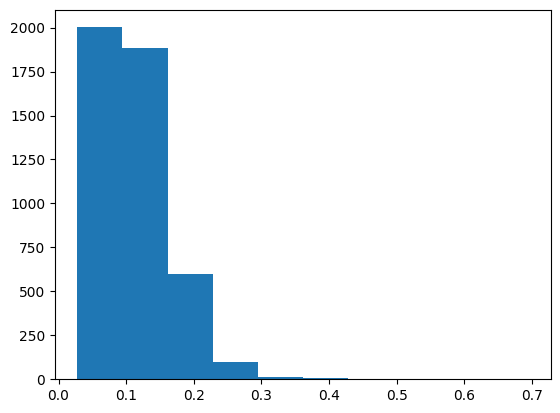

In [67]:
plt.hist(preds_std);

In [68]:
min(preds_std), max(preds_std), max(preds_std)/min(preds_std)

(0.0278703429008966, 0.694632232470765, 24.923705996039914)

As is the case in the text, the standard deviation varies widely for each prediction, with about a 20x difference between the smallest and largest standard deviations.

### Feature Importance

In [69]:
def rf_feat_importance(m, df):
  return pd.DataFrame({
      'cols': df.columns,
      'imp': m.feature_importances_}
                      ).sort_values('imp', ascending=False)

In [70]:
fi = rf_feat_importance(m, xs)
fi[:10]

,cols,imp
101,structuretaxvaluedollarcnt,0.068990
105,taxamount,0.063532
80,lotsizesquarefeet,0.056561
102,taxvaluedollarcnt,0.054181
78,latitude,0.053154
104,landtaxvaluedollarcnt,0.052342
67,finishedsquarefeet12,0.050304
66,calculatedfinishedsquarefeet,0.050167
99,yearbuilt,0.048438
55,parcelid,0.048166


Interesting to see that in this case, which is different than the textbook example, the feature importance across the top-10 most important features is pretty similar. The top-10 most important features include 4 columns related to the tax value of the property, 2 columns related to the square feet of the property or land, location (lat/long) columns, the year the property was built and `parcelid`.

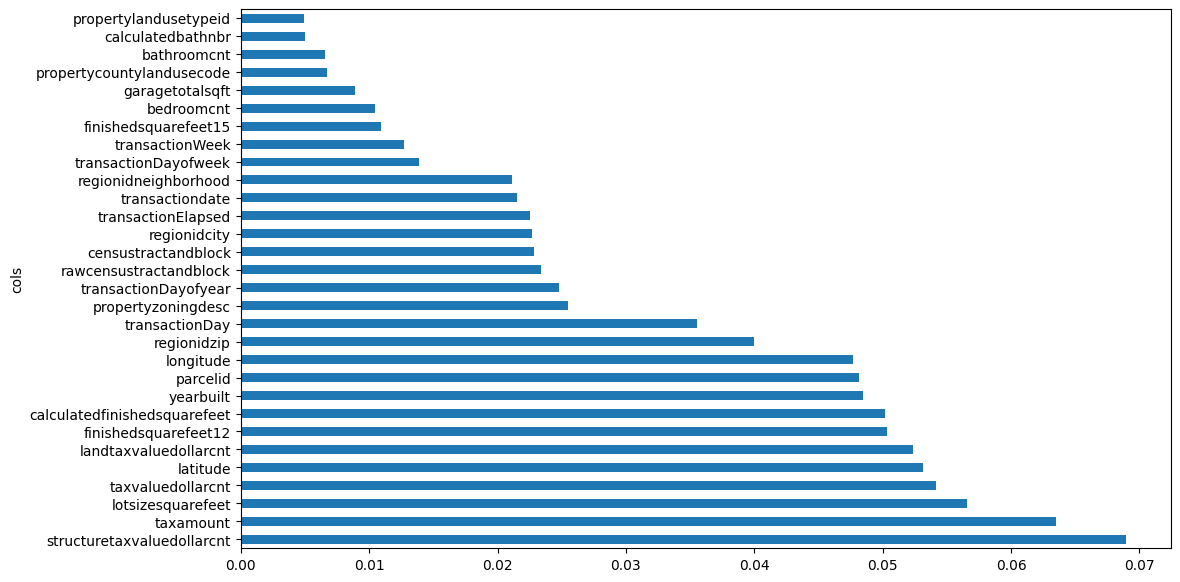

In [71]:
def plot_fi(fi):
  return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

plot_fi(fi[:30]);

### Removing Low-Importance Variables

I'll retrain the model after removing features with low importance (0.005), which leaves me with 28 columns instead of 73.

In [72]:
len(df.columns)

73

In [73]:
to_keep = fi[fi.imp>0.005].cols
len(to_keep)

28

In [74]:
xs_imp = xs[to_keep]
valid_xs_imp = valid_xs[to_keep]
m = rf(xs_imp, y);

In [75]:
m_mae(m, xs_imp, y), m_mae(m, valid_xs_imp, valid_y)

(0.05664031645342886, 0.07351868669419753)

The training error increased slightly and the validation decreased when compared to the model containing all 73 columns.

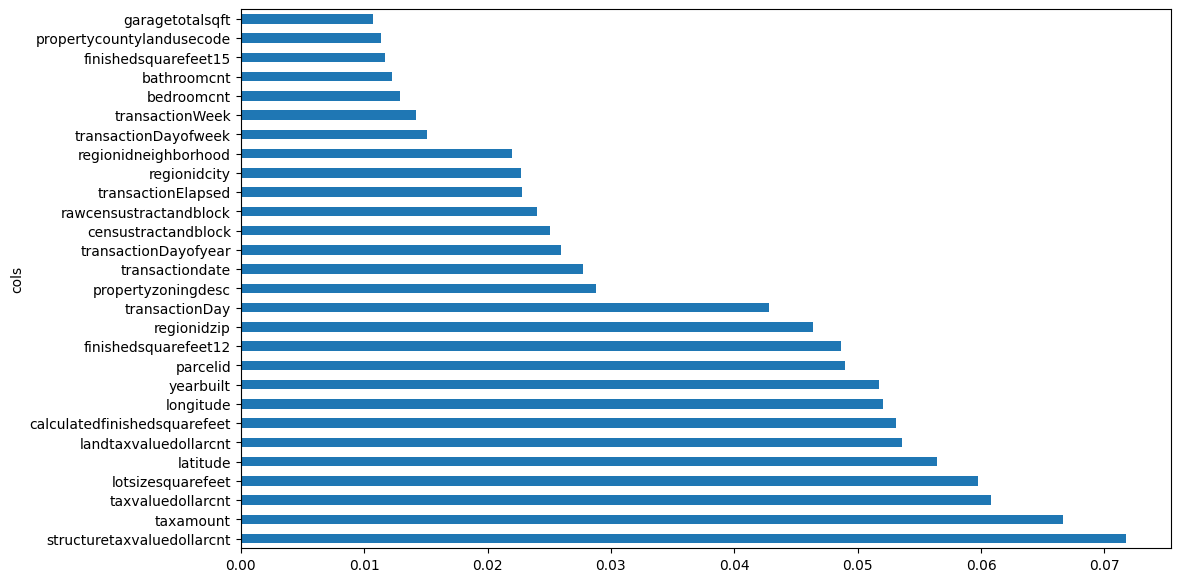

In [76]:
plot_fi(rf_feat_importance(m, xs_imp));

### Removing Redundant Features

In [77]:
from scipy.cluster import hierarchy as hc

def cluster_columns(df, figsize=(10,6), font_size=12):
    corr = np.round(scipy.stats.spearmanr(df).correlation, 4)
    corr_condensed = hc.distance.squareform(1-corr)
    z = hc.linkage(corr_condensed, method='average')
    fig = plt.figure(figsize=figsize)
    hc.dendrogram(z, labels=df.columns, orientation='left', leaf_font_size=font_size)
    plt.show()

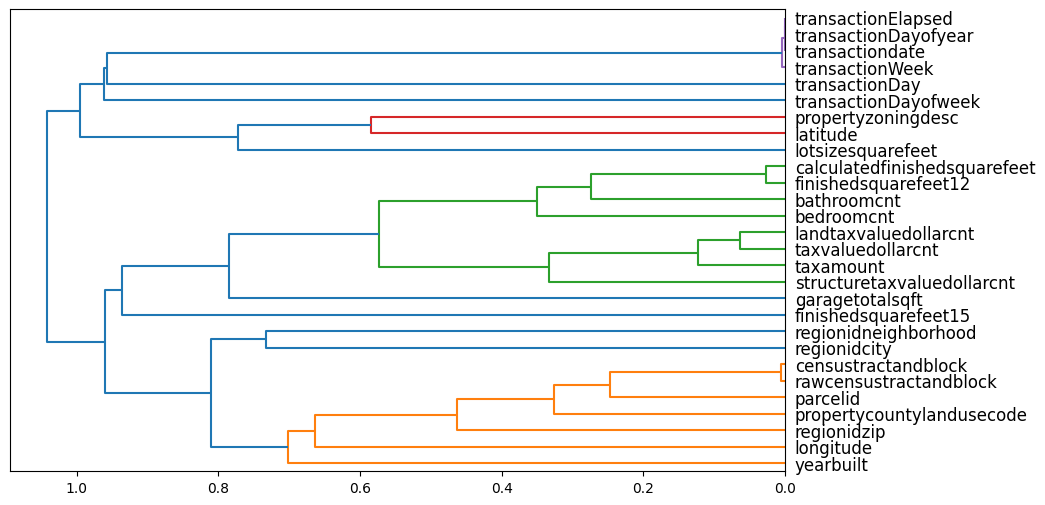

In [79]:
cluster_columns(xs_imp)

The most similar columns are the columns that are paired together at the right edge of the plot.

As is done in the text, I'll create a function that quickly trains a smaller random forest (using only a quarter of the max samples used earlier) and returns the OOB score (which is 1.0 for a perfect model and 0.0 for a random model):

In [80]:
def get_oob(df):
  m = RandomForestRegressor(n_estimators=40, min_samples_leaf=15,
                            max_samples=10_000, max_features=0.5, n_jobs=-1, oob_score=True)
  m.fit(df, y)
  return m.oob_score_

In [81]:
# baseline
get_oob(xs_imp)

0.011697584107195569

Remove each of the potentially redundant variables and compare the OOB score to the baseline:

In [82]:
{c: get_oob(xs_imp.drop(c, axis=1)) for c in (
    'transactionElapsed', 'transactiondate', 'transactionDayofyear', 'transactionWeek',
    'finishedsquarefeet12', 'calculatedfinishedsquarefeet',
    'landtaxvaluedollarcnt', 'taxvaluedollarcnt',
    'censustractandblock', 'rawcensustractandblock')}

{'transactionElapsed': 0.013909569573363978,
 'transactiondate': 0.01231524099367498,
 'transactionDayofyear': 0.013553857476552356,
 'transactionWeek': 0.013361881019678945,
 'finishedsquarefeet12': 0.013417734028419948,
 'calculatedfinishedsquarefeet': 0.013048107145456234,
 'landtaxvaluedollarcnt': 0.012660367356422841,
 'taxvaluedollarcnt': 0.0128850786659368,
 'censustractandblock': 0.012599787787639927,
 'rawcensustractandblock': 0.012632301991060135}

I'll pick the variables where their removal increased the OOB score.

In [83]:
to_drop = ['transactionElapsed',
           'transactionDayofyear',
           'transactionWeek',
           'finishedsquarefeet12',
           'taxvaluedollarcnt',
           'rawcensustractandblock']

get_oob(xs_imp.drop(to_drop, axis=1))

0.012975220827415757

Great! I now have a few less features and the OOB score increased.

I'll save the data and model for later so that I can maintain the previous work:

In [ ]:
xs_final = xs_imp.drop(to_drop, axis=1)
valid_xs_final = valid_xs_imp.drop(to_drop, axis=1)

In [92]:
# check accuracy
m = rf(xs_final, y)
m_mae(m, xs_final, y), m_mae(m, valid_xs_final, valid_y)

(0.05687215149513172, 0.07364818858339096)

In [94]:
save_pickle('xs_final.pkl', xs_final)
save_pickle('valid_xs_final.pkl', valid_xs_final)
save_pickle('m.pkl', m)

### Partial Dependence

As done in the text, I'll look at the distribution of the top 2 most important features.

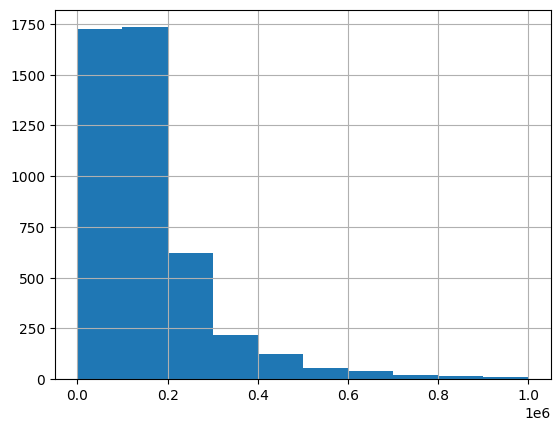

In [86]:
valid_xs_final.structuretaxvaluedollarcnt.hist(range=[0,0.1e7]);

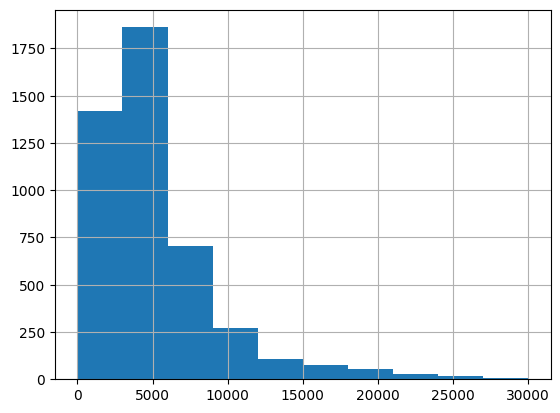

In [87]:
valid_xs_final.taxamount.hist(range=[0,30_000]);

Next, I'll create partial dependence plots, which observe how the dependent variable varies with respect to each of these variables.

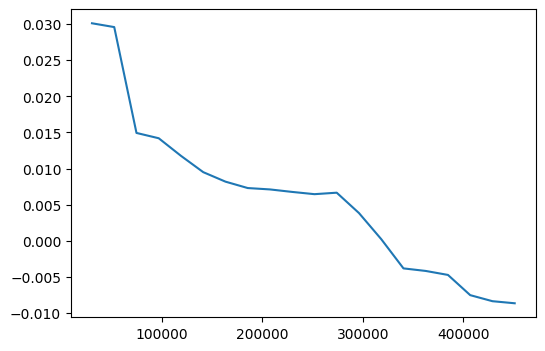

In [88]:
from sklearn.inspection import partial_dependence

fig, ax = plt.subplots(figsize=(6,4))
pdp = partial_dependence(m, valid_xs_final, ['structuretaxvaluedollarcnt', 'taxamount'],
                        grid_resolution=20)

ax.plot(pdp['values'][0], pdp['average'].mean(axis=1).squeeze());

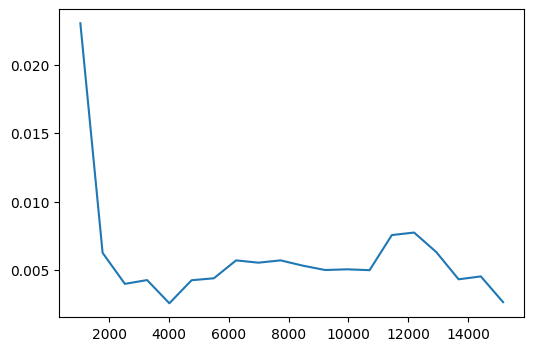

In [89]:
fig, ax = plt.subplots(figsize=(6,4))
ax.plot(pdp['values'][1], pdp['average'].mean(axis=2).squeeze());

In both cases, the `logerror` generally decreases as the value of the variable increases. Although for larger `taxamount` values, the `logerror` increases before decreasing again.

### Tree Interpreter

In [3]:
xs_final = load_pickle('xs_final.pkl')
valid_xs_final = load_pickle('valid_xs_final.pkl')
m = load_pickle('m.pkl')
xs_final.shape, valid_xs_final.shape

((85670, 26), (4605, 26))

I'll look at the contribution of different features to the prediction of a single row:

In [95]:
row = valid_xs_final.iloc[:1]
row

,structuretaxvaluedollarcnt,taxamount,lotsizesquarefeet,latitude,...,bedroomcnt,garagetotalsqft,propertycountylandusecode,bathroomcnt
3421,128318.0,4382.959961,10440.0,33844408.0,...,2.0,400.0,59,2.5


In [96]:
from treeinterpreter import treeinterpreter
prediction, bias, contributions = treeinterpreter.predict(m, row.values)

In [99]:
prediction[0], bias[0], contributions[0].sum(), contributions[0].sum()/prediction[0]

(array([0.01924753]),
 0.011195491642025518,
 0.00805203672769338,
 array([0.41834134]))

The features' contribution to the prediction is about 40%.

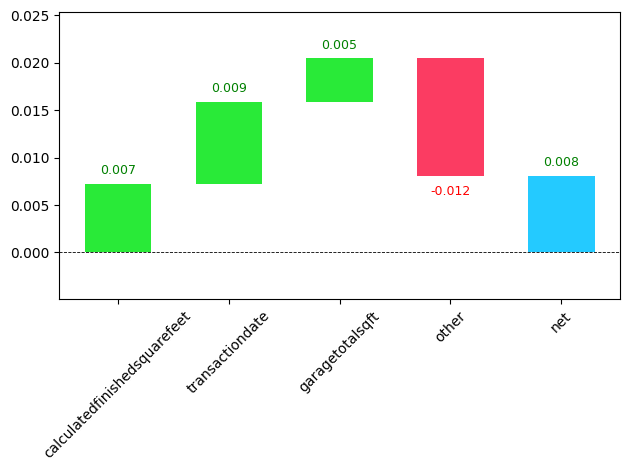

In [103]:
from waterfall_chart import plot as waterfall
waterfall(valid_xs_final.columns, contributions[0], threshold=0.5,
          rotation_value=45, formatting='{:,.3f}');

## Finding Out-of-Domain Data

In order to understand which features in the validation set are out-of-domain for the training set, we'll train a model to predict whether a row in the data is in the training or validation set---the features with the highest importance in this model are the features that are most different between the two datasets.

In [104]:
df_dom = pd.concat([xs_final, valid_xs_final])
is_valid = np.array([0]*len(xs_final) + [1]*len(valid_xs_final))

df_dom.shape, len(is_valid)

((90275, 22), 90275)

In [105]:
m = rf(df_dom, is_valid)
rf_feat_importance(m, df_dom)[:6]

,cols,imp
14,transactiondate,0.996253
16,transactionDayofweek,0.001673
10,transactionDay,0.001005
1,taxamount,0.000206
9,regionidzip,0.000110
3,latitude,0.000095


Of course `transactiondate` is different between the two sets---that was done intentionally to match the way the competition splits training and test data. The next two most important features are relatively unimportant, but I'll still remove each of the three and see if it improves the model:

In [106]:
# baseline
m = rf(xs_final, y)
print('orig', m_mae(m, valid_xs_final, valid_y))

for c in ('transactiondate', 'transactionDayofweek', 'transactionDay'):
  m = rf(xs_final.drop(c, axis=1), y)
  print(c, m_mae(m, valid_xs_final.drop(c,axis=1), valid_y))

orig 0.07414874259938188
transactiondate 0.07169995892420085
transactionDayofweek 0.07419470238304429
transactionDay 0.07380756091486504


I'll remove `transactiondate` and `transactionDay`, which should reduce the error.

In [107]:
time_vars = ['transactiondate', 'transactionDay']
xs_final_time = xs_final.drop(time_vars, axis=1)
valid_xs_time = valid_xs_final.drop(time_vars, axis=1)

m = rf(xs_final_time, y)
m_mae(m, valid_xs_time, valid_y)

0.07191006179240521

In [108]:
0.07191006179240521/0.07414874259938188

0.9698082431542766

Great! My error decreased by about 3%.

At this point in the textbook they train the model on recent years' data. For this dataset, all of the data comes from the same year so it doesn't make sense to do the same.

## Using a Neural Network

In [116]:
df_nn = pd.read_csv(path/'train_2016_v2.csv', low_memory=False)
df_nn = df_nn.merge(properties_2016, how='left', left_on='parcelid', right_on='parcelid')
df_nn['transactiondate'] = pd.to_datetime(df_nn['transactiondate'])
df_nn = add_datepart(df_nn, 'transactiondate')

In [117]:
df_nn_final = df_nn[list(xs_final_time.columns) + [dep_var]]

In [118]:
xs_final_time.shape, df_nn_final.shape

((85670, 20), (90275, 21))

In [120]:
cont_nn, cat_nn = cont_cat_split(df_nn_final, max_card=9000, dep_var=dep_var)

In [125]:
# look at cardinality
df_nn_final[cat_nn].nunique()

propertyzoningdesc           1996
transactionDayofweek            7
propertycountylandusecode      77
dtype: int64

In [124]:
# look at cardinality
df_nn_final[cont_nn].nunique()

structuretaxvaluedollarcnt      55450
taxamount                       85110
lotsizesquarefeet               20016
latitude                        73312
landtaxvaluedollarcnt           57066
calculatedfinishedsquarefeet     5102
yearbuilt                         130
parcelid                        90150
longitude                       71900
regionidzip                       388
censustractandblock             42398
regionidcity                      177
regionidneighborhood              494
finishedsquarefeet15             1915
bedroomcnt                         17
garagetotalsqft                   870
bathroomcnt                        23
dtype: int64

Some of the continuous variables are categorical in nature (`latitude`, `censustractandblock`, etc.) but have very high cardinality (tens of thousands) so instead of creating very large embeddings, I'll keep them as continuous variables.

Some of the other variables that `cont_cat_split` has determined to be continuous have a relatively small cardinality (`regionidzip`, `regionidcity`, and `regionidneighborhood`) so I'll move those over to `cat_nn`.

In [129]:
cont_nn.remove('regionidzip')
cont_nn.remove('regionidcity')
cont_nn.remove('regionidneighborhood')

cat_nn.append('regionidzip')
cat_nn.append('regionidcity')
cat_nn.append('regionidneighborhood')

In [130]:
df_nn_final[cat_nn].nunique()

propertyzoningdesc           1996
transactionDayofweek            7
propertycountylandusecode      77
regionidzip                   388
regionidcity                  177
regionidneighborhood          494
dtype: int64

In [131]:
df_nn_final[cont_nn].nunique()

structuretaxvaluedollarcnt      55450
taxamount                       85110
lotsizesquarefeet               20016
latitude                        73312
landtaxvaluedollarcnt           57066
calculatedfinishedsquarefeet     5102
yearbuilt                         130
parcelid                        90150
longitude                       71900
censustractandblock             42398
finishedsquarefeet15             1915
bedroomcnt                         17
garagetotalsqft                   870
bathroomcnt                        23
dtype: int64

I can now go ahead and build a `TabularPandas` object:

In [132]:
procs_nn = [Categorify, FillMissing, Normalize]
to_nn = TabularPandas(df_nn_final, procs_nn, cat_nn, cont_nn, splits=splits, y_names=dep_var)

and `DataLoaders`:

In [133]:
dls = to_nn.dataloaders(1024)

Define the `y_range` for regression:

In [134]:
y = to_nn.train.y
y.min(), y.max()

(-4.605, 4.737)

And train the neural net (I'm using the same number of `layers` as they did in the textbook):

SuggestedLRs(valley=0.00019054606673307717)

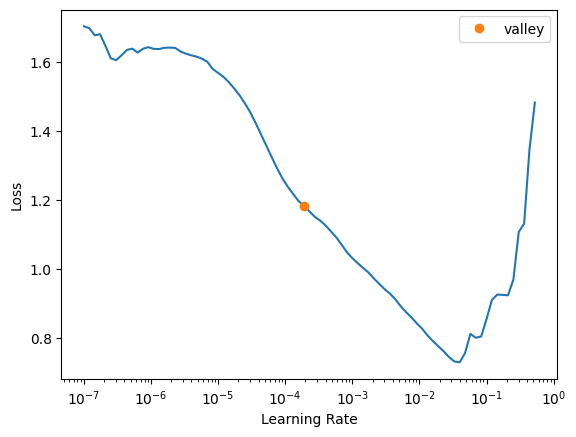

In [135]:
from fastai.tabular.all import *
learn = tabular_learner(dls, y_range=(-5,5), layers=[500,250],
                        n_out=1, loss_func=F.mse_loss)

learn.lr_find()

The loss curve looks stable and reasonable so I'll go ahead and use the suggested valley learning rate.

In [136]:
learn.fit_one_cycle(5, 2e-4)

epoch,train_loss,valid_loss,time
0,0.295388,0.082879,00:07
1,0.101962,0.052496,00:04
2,0.059026,0.042152,00:05
3,0.044456,0.038492,00:04
4,0.038725,0.038634,00:05


The validation loss increases between the 4th and 5th epoch so the model is starting to overfit.

In [138]:
preds, targs = learn.get_preds()
mae(preds, targs).item()

0.11708459258079529

In [139]:
0.11/0.07

1.5714285714285714

The mean absolute error of the neural net predictions is about 60% larger than my random forest!

## Ensembling

The final part of this exercise is ensembling the predictions between my random forest and my neural net, and seeing how the error compares.

In [140]:
rf_preds = m.predict(valid_xs_time)
ens_preds = (to_np(preds.squeeze()) + rf_preds) / 2

In [147]:
def mae(pred, y): return (pred - y).abs().mean()

In [148]:
mae(ens_preds, valid_y)

0.08611476519897165

While smaller than my neural net's error, this error is still significantly larger than my random forest.

## Final Thoughts

This was a really enjoyable exercise. I had a lot of fun working through the textbook's process using a different dataset. There were many similarities (time-related variables were causing out-of-domain issues for the validation set) and differences (my neural net performed worse than my random forest, while in the chapter the results were flipped).

I noticed as I was re-running the code in this notebook that there were slight differences each time I created my random forest. For example, sometimes `parcelid` was the 11th-most important feature, other times it was in the top 10. There were also different redundant features for each model run. Is this normal and expected? Or is there something about this data which makes the modeling process less consistent?

I'll end by summarizing my models' results again, noting that my random forest beat the first place entry in the private leaderboard (which had an error of 0.074):

|Model|Mean Absolute Error|
|:-:|:-:|
|Random Forest|0.072|
|Neural Net|0.117|
|Ensemble of both|0.086|

I hope you enjoyed this blog post!